# TP2 - CLASE 3

## 1. Medición de foco en toda la imagen

### Objetivo:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: **focus_video.mov**.

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper **"Image Sharpness Measure for Blurred Images in Frequency Domain"** y realizar tres experimentos:

1. **Medición sobre todo el frame.**
2. **Medición sobre una ROI ubicada en el centro del frame.** Área de la ROI = 5 o 10% del área total del frame.

### Opcional:
1. **Medición sobre una matriz de enfoque** compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc. (al menos 3)

### Para cada experimento se debe presentar:
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detectó el punto de máximo enfoque.

In [1]:
"""Image quality analysis and focus detection libraries."""
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple, Optional, Dict, List, Union

In [2]:
# open video file and extract metadata
video_path = "data/focus_video.mov"

if os.path.exists(video_path):
    cap = cv2.VideoCapture(video_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps if fps > 0 else 0
    
    video_info = {
        'frames': frame_count,
        'resolution': f"{width}x{height}",
        'width': width,
        'height': height,
        'fps': fps,
        'duration_seconds': duration,
        'codec': int(cap.get(cv2.CAP_PROP_FOURCC))
    }
    
    cap.release()
    
    for key, value in video_info.items():
        if key == 'codec':
            codec_str = ''.join([chr((value >> 8 * i) & 0xFF) for i in range(4)])
            print(f"{key}: {codec_str}")
        elif key == 'duration_seconds':
            print(f"{key}: {value:.2f}")
        elif key == 'fps':
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value}")
            
else:
    print(f"Video file not found: {video_path}")

frames: 171
resolution: 640x360
width: 640
height: 360
fps: 29.97
duration_seconds: 5.71
codec: h264


In [3]:
# create a video showing the Fourier transform of each frame
os.makedirs("outputs", exist_ok=True)

input_path = "data/focus_video.mov"
output_path = "outputs/fourier_transform_video.mp4"

cap = cv2.VideoCapture(input_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_shift) + 1)
    
    magnitude_normalized = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    magnitude_bgr = cv2.cvtColor(magnitude_normalized, cv2.COLOR_GRAY2BGR)
    
    out.write(magnitude_bgr)

cap.release()
out.release()

print(f"Fourier transform video saved to: {output_path}")

Fourier transform video saved to: outputs/fourier_transform_video.mp4


Del PAPPER
3. Proposed Algorithm for calculating Image Quality measure
3.1 Algorithm for image quality measure
Input: Image I of size M×N.
Output: Image Quality measure (FM) where FM stands for Frequency Domain Image Blur Measure
Step 1: Compute F which is the Fourier Transform representation of image I
Step 2: Find Fc which is obtained by shifting the origin of F to centre.
Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
Step 6: Calculate Image Quality measure (FM) from equation (1).
FM = TH / (M * N) (1)

In [4]:
def calculate_image_quality(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shift)
    
    M = np.max(magnitude_spectrum)
    thres = M / 1000
    TH = np.sum(magnitude_spectrum > thres)
    N = image.shape[0] * image.shape[1]
    
    FM = TH / (M * N) if M * N != 0 else 0
    return FM

In [5]:
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)
quality_scores = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    quality = calculate_image_quality(frame)
    quality_scores.append(quality)
cap.release()


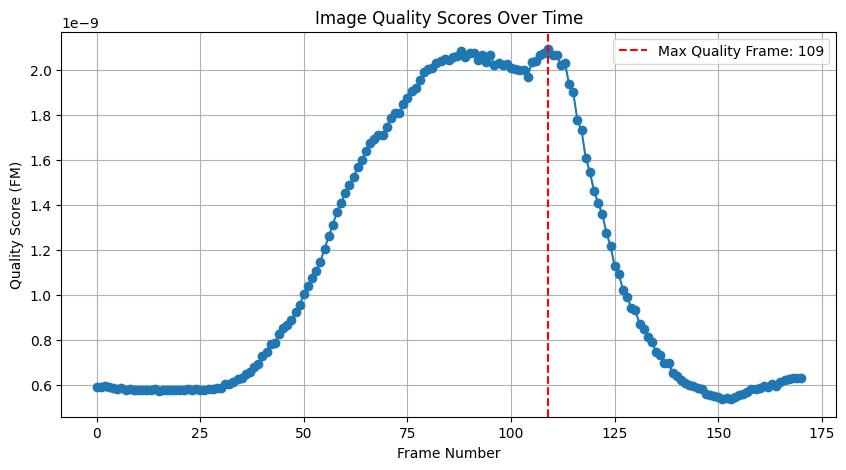

Max quality score: 0.000000 at frame 109


In [6]:
# Plot quality scores over time
max = np.argmax(quality_scores) if quality_scores else 0
plt.figure(figsize=(10, 5))
plt.plot(quality_scores, marker='o')
plt.axvline(x=max, color='r', linestyle='--', label=f'Max Quality Frame: {max}')
plt.title('Image Quality Scores Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Quality Score (FM)')
plt.legend()
plt.grid()
plt.show()
print(f"Max quality score: {quality_scores[max]:.6f} at frame {max}")

In [ ]:
def calculate_image_quality_roi(image, porcentage_roi=0.05):
    im=image.copy()
    h, w, _ = im.shape
    roi_h, roi_w = int(h * porcentage_roi), int(w * porcentage_roi)
    start_h, start_w = (h - roi_h) // 2, (w - roi_w) // 2
    roi = im[start_h:start_h + roi_h, start_w:start_w + roi_w]
    FM=calculate_image_quality(roi)
    return FM

In [ ]:
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)
quality_scores_5p = []
quality_scores_10p = []
while cap.isOpened():
    ret, frame = cap.read()
    quality_5p = calculate_image_quality_roi(frame, porcentage_roi=0.05)
    quality_scores_5p.append(quality_5p)
    quality_10p = calculate_image_quality_roi(frame, porcentage_roi=0.10)
    quality_scores_10p.append(quality_10p)
cap.release()

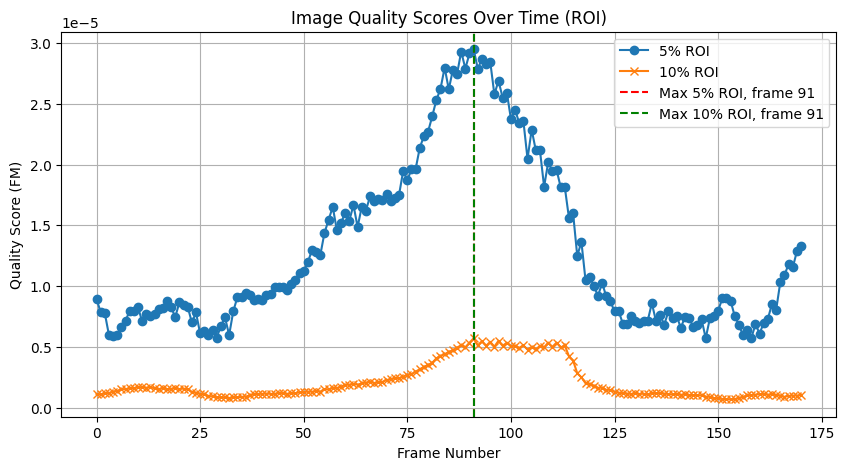

Max quality score (5% ROI): 0.000029 at frame 91
Max quality score (10% ROI): 0.000006 at frame 91


In [9]:
# Plot quality scores ROI over time and the max value
max_5p = np.argmax(quality_scores_5p) if quality_scores_5p else 0
max_10p = np.argmax(quality_scores_10p) if quality_scores_10p else 0
plt.figure(figsize=(10, 5))
plt.plot(quality_scores_5p, marker='o', label='5% ROI')
plt.plot(quality_scores_10p, marker='x', label='10% ROI')
plt.axvline(x=max_5p, color='r', linestyle='--', label=f'Max 5% ROI, frame {max_5p}' if quality_scores_5p else '')
plt.axvline(x=max_10p, color='g', linestyle='--', label=f'Max 10% ROI, frame {max_10p}' if quality_scores_10p else '')
plt.title('Image Quality Scores Over Time (ROI)')
plt.xlabel('Frame Number')
plt.ylabel('Quality Score (FM)')
plt.legend()
plt.grid()
plt.show()
print(f"Max quality score (5% ROI): {quality_scores_5p[max_5p]:.6f} at frame {max_5p}")
print(f"Max quality score (10% ROI): {quality_scores_10p[max_10p]:.6f} at frame {max_10p}")

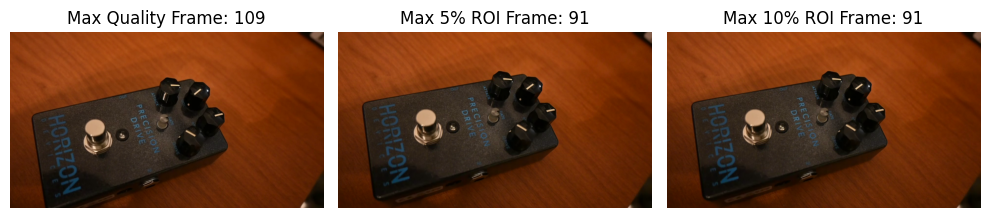

In [ ]:
# Plot the max quality frame for all the algorithms
max = np.argmax(quality_scores) if quality_scores else 0
max_5p = np.argmax(quality_scores_5p) if quality_scores_5p else 0
max_10p = np.argmax(quality_scores_10p) if quality_scores_10p else 0
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)
quality_scores_5p = []
quality_scores_10p = []
while cap.isOpened():
    ret, frame = cap.read()
    if cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 == max:
        max_frame = frame.copy()
    if cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 == max_5p:
        max_frame_5p = frame.copy()
    if cap.get(cv2.CAP_PROP_POS_FRAMES) - 1 == max_10p:
        max_frame_10p = frame.copy()
cap.release()
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
plt.title(f'Max Quality Frame: {max}')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(max_frame_5p, cv2.COLOR_BGR2RGB))
plt.title(f'Max 5% ROI Frame: {max_5p}')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(max_frame_10p, cv2.COLOR_BGR2RGB))
plt.title(f'Max 10% ROI Frame: {max_10p}')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def calculate_image_quality_matrix(image, matrix_size=(3, 3), roi_percentage=0.6):
    rows, cols = matrix_size
    h, w = image.shape[:2]
    
    # Definir la ROI centrada
    roi_h = int(h * roi_percentage)
    roi_w = int(w * roi_percentage)
    roi_start_h = (h - roi_h) // 2
    roi_start_w = (w - roi_w) // 2
    roi_end_h = roi_start_h + roi_h
    roi_end_w = roi_start_w + roi_w
    
    total_rows = rows * 2  # filas totales incluyendo espacios
    total_cols = cols * 2  # columnas totales incluyendo espacios
    
    cell_h = roi_h // total_rows
    cell_w = roi_w // total_cols
    
    quality_matrix = np.zeros((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            # Calcular posición saltando una celda
            actual_row = i * 2  # Saltar una fila entre celdas
            actual_col = j * 2  # Saltar una columna entre celdas
            
            # Posiciones relativas dentro de la ROI
            start_h_roi = actual_row * cell_h
            end_h_roi = start_h_roi + cell_h
            start_w_roi = actual_col * cell_w
            end_w_roi = start_w_roi + cell_w
            
            # Convertir a coordenadas absolutas de la imagen
            start_h = roi_start_h + start_h_roi
            end_h = roi_start_h + end_h_roi
            start_w = roi_start_w + start_w_roi
            end_w = roi_start_w + end_w_roi
            
            # Asegurar que no excedamos los límites de la ROI
            end_h = min(end_h, roi_end_h)
            end_w = min(end_w, roi_end_w)
            
            # Extraer la celda y calcular su calidad
            if start_h < roi_end_h and start_w < roi_end_w:
                cell = image[start_h:end_h, start_w:end_w]
                if cell.size > 0: 
                    quality_matrix[i, j] = calculate_image_quality(cell)
                
    return quality_matrix

In [ ]:
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)

matrix_sizes = [(3, 3), (5, 7), (7, 5)]
roi_percentage = 0.6  # ROI del 60%
quality_scores_matrix = {str(size): [] for size in matrix_sizes}

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Processing {frame_count} frames for matrix quality analysis...")

for frame_idx in tqdm(range(frame_count), desc="Calculating matrix quality scores"):
    ret, frame = cap.read()
    
    for matrix_size in matrix_sizes:
        quality_matrix = calculate_image_quality_matrix(frame, matrix_size, roi_percentage)
        avg_quality = np.mean(quality_matrix)
        quality_scores_matrix[str(matrix_size)].append(avg_quality)

cap.release()

Processing 171 frames for matrix quality analysis...


Calculating matrix quality scores: 100%|██████████| 171/171 [00:00<00:00, 248.06it/s]


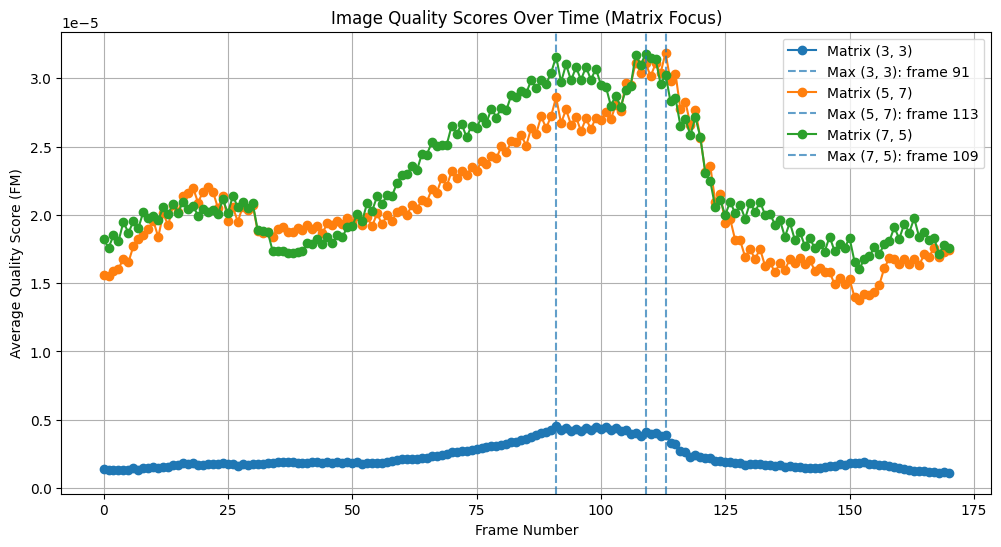

In [13]:
plt.figure(figsize=(12, 6))
for i, (matrix_size, scores) in enumerate(quality_scores_matrix.items()):
    max_idx = np.argmax(scores) if scores else 0
    plt.plot(scores, marker='o', label=f'Matrix {matrix_size}')
    plt.axvline(x=max_idx, linestyle='--', alpha=0.7, label=f'Max {matrix_size}: frame {max_idx}')

plt.title('Image Quality Scores Over Time (Matrix Focus)')
plt.xlabel('Frame Number')
plt.ylabel('Average Quality Score (FM)')
plt.legend()
plt.grid()
plt.show()


Drawing matrix overlay: 100%|██████████| 35/35 [00:00<00:00, 70577.23it/s]


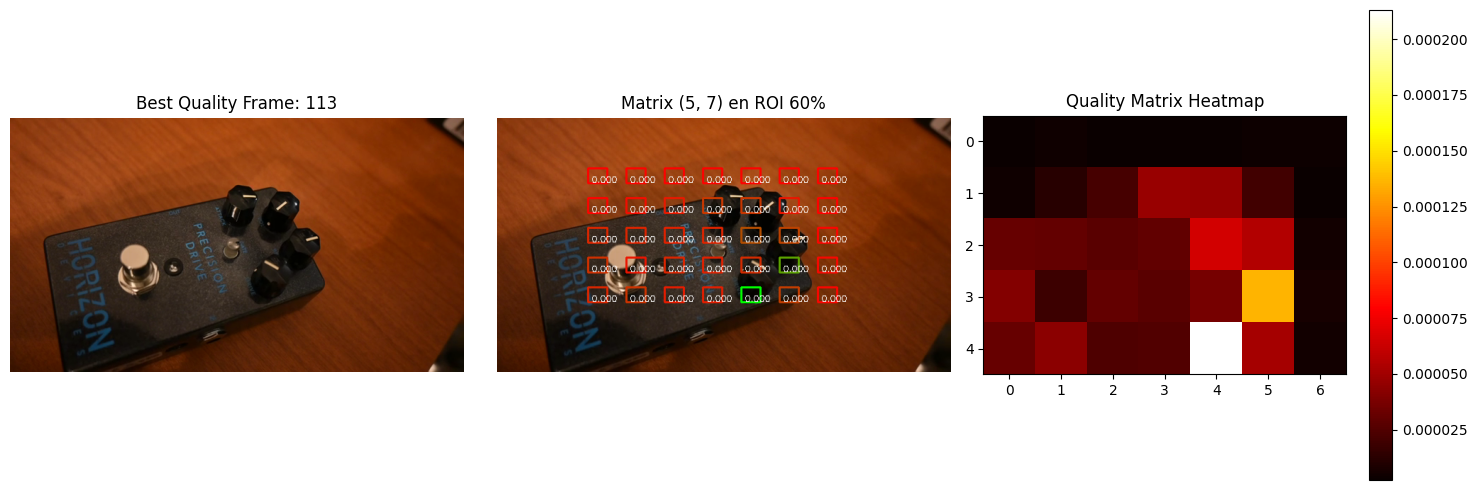

In [ ]:
def visualize_matrix_overlay(image, matrix_size, quality_matrix, roi_percentage=0.6):
    """
    Visualiza la matriz de calidad superpuesta en la imagen con patrón equiespaciado
    dentro de una ROI (una celda sí, una celda no)
    """
    h, w = image.shape[:2]
    rows, cols = matrix_size
    
    # Calcular ROI centrada
    roi_h = int(h * roi_percentage)
    roi_w = int(w * roi_percentage)
    roi_start_h = (h - roi_h) // 2
    roi_start_w = (w - roi_w) // 2
    roi_end_h = roi_start_h + roi_h
    roi_end_w = roi_start_w + roi_w
    
    total_rows = rows * 2
    total_cols = cols * 2
    
    cell_h = roi_h // total_rows
    cell_w = roi_w // total_cols
    
    overlay = image.copy()
    
    total_cells = rows * cols
    with tqdm(total=total_cells, desc="Drawing matrix overlay") as pbar:
        for i in range(rows):
            for j in range(cols):
                # Calcular posición con el patrón equiespaciado dentro de la ROI
                actual_row = i * 2
                actual_col = j * 2
                
                # Posiciones relativas dentro de la ROI
                start_h_roi = actual_row * cell_h
                end_h_roi = start_h_roi + cell_h
                start_w_roi = actual_col * cell_w
                end_w_roi = start_w_roi + cell_w
                
                # Convertir a coordenadas absolutas
                start_h = roi_start_h + start_h_roi
                end_h = roi_start_h + end_h_roi
                start_w = roi_start_w + start_w_roi
                end_w = roi_start_w + end_w_roi
                
                # Asegurar que no excedamos los límites de la ROI
                end_h = min(end_h, roi_end_h)
                end_w = min(end_w, roi_end_w)
                
                quality_val = quality_matrix[i, j]
                max_quality = np.max(quality_matrix)
                
                # Color basado en la calidad relativa
                intensity = int(255 * (quality_val / max_quality)) if max_quality > 0 else 0
                color = (0, intensity, 255 - intensity)  # De azul (baja calidad) a verde (alta calidad)
                
                # Dibujar rectángulo y texto
                cv2.rectangle(overlay, (start_w, start_h), (end_w, end_h), color, 2)
                cv2.putText(overlay, f'{quality_val:.3f}', (start_w + 5, start_h + 20), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
                
                pbar.update(1)
    
    return overlay

best_score = 0
best_matrix_size = None
for matrix_key, scores in quality_scores_matrix.items():
    if scores and np.max(scores) > best_score:
        best_score = np.max(scores)
        best_matrix_size = matrix_key

best_frame_idx = np.argmax(quality_scores_matrix[best_matrix_size]) if best_matrix_size else 0

cap = cv2.VideoCapture(input_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, best_frame_idx)
ret, best_frame = cap.read()
cap.release()

matrix_size = eval(best_matrix_size)
quality_matrix = calculate_image_quality_matrix(best_frame, matrix_size, roi_percentage=0.6)
overlay_image = visualize_matrix_overlay(best_frame, matrix_size, quality_matrix, roi_percentage=0.6)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(best_frame, cv2.COLOR_BGR2RGB))
plt.title(f'Best Quality Frame: {best_frame_idx}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.title(f'Matrix {matrix_size} en ROI 60%')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(quality_matrix, cmap='hot', interpolation='nearest')
plt.title('Quality Matrix Heatmap')
plt.colorbar()

plt.tight_layout()
plt.show()

## 2. Cambiar la métrica de enfoque
Eligiendo uno de los algoritmos explicados en el apéndice de: **"Analysis of focus measure operators in shape from focus"**.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

### Resultados esperados:
- Matriz de enfoque superpuesta a uno de los frames del video
- Gráfico de la métrica asociado al experimento

### Puntos extra:
Aplicar unsharp masking para expandir la zona de enfoque y recalcular la métrica.

Analizando las conclusiones del paper **"Analysis of focus measure operators in shape from focus"** vemos que el mejor operador para medir el enfoque cuando hay ruido gauseano es el gray-level variance (STA3, en el paper) que sufre poco al aumentar el ruido.
En cambio el mejor operador en generel es el Laplacian modificado (LAP2 en el paper). Este operador es sensible al ruido por que realiza una segunda derivada, pero es el que mejor resultados da en condiciones ideales.
Por lo explicado anteriormente se van a implementar ambos y comparar resultados para nuestro video.

## 1. Operador (Varianza - STA3)

STA3(i, j) = (1 / N) * SUM((x, y) en W_i,j) [ (I(x, y) - mu_i,j) ^ 2 ]
mu_i,j = (1 / N) * SUM((x, y) en W_i,j) [ I(x, y) ]


## 2. Operador (Laplaciano Modificado - LAP2)
LAP2(x, y) = SUM((i, j) en W_x,y) [ DmI(i, j) ]
DmI(i, j) = | I * LX | + | I * LY |


In [ ]:
def calculate_sta3_focus_measure(image: np.ndarray, window_size: int = 3) -> np.ndarray:
    """Calculate STA3 (Gray-level Variance) focus measure.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image.copy()
    gray = gray.astype(np.float32)
    
    h, w = gray.shape
    half_window = window_size // 2
    focus_map = np.zeros((h, w), dtype=np.float32)
        

    for i in range(half_window, h - half_window):
        for j in range(half_window, w - half_window):
            # Extract window
            window = gray[i-half_window:i+half_window+1, j-half_window:j+half_window+1]
            
            # Calculate variance
            window_mean = np.mean(window)
            variance = np.mean((window - window_mean) ** 2)
            focus_map[i, j] = variance
            
    
    return focus_map

def calculate_lap2_focus_measure(image: np.ndarray, window_size: int = 3) -> np.ndarray:
    """Calculate LAP2 (Modified Laplacian) focus measure.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image.copy()
    gray = gray.astype(np.float32)
    
    h, w = gray.shape
    half_window = window_size // 2
    
    # Laplacian masks
    mask_x = np.array([-1, 2, -1], dtype=np.float32)
    mask_y = np.array([[-1], [2], [-1]], dtype=np.float32)
    
    # Calculate derivatives
    derivative_image = np.zeros((h, w), dtype=np.float32)
    

    for i in range(1, h - 1):
        for j in range(1, w - 1):
            # Horizontal and vertical derivatives
            dx = np.sum(gray[i, j-1:j+2] * mask_x)
            dy = np.sum(gray[i-1:i+2, j] * mask_y.flatten())
            derivative_image[i, j] = abs(dx) + abs(dy)

    
    # Accumulate in windows
    focus_map = np.zeros((h, w), dtype=np.float32)
    

    for x in range(half_window, h - half_window):
        for y in range(half_window, w - half_window):
            window = derivative_image[x-half_window:x+half_window+1, y-half_window:y+half_window+1]
            focus_map[x, y] = np.sum(window)

    
    return focus_map

def max_focus_points(focus_map: np.ndarray) -> Tuple[List[Tuple[int, int]], float]:
    """Get pixels with maximum focus value.
    """
    max_value = np.max(focus_map)
    max_positions = np.where(focus_map == max_value)
    max_points = list(zip(max_positions[0], max_positions[1]))
    
    return max_points, max_value

def create_focus_points_video(input_path, output_path, algorithm='sta3', window_size=3):
    """
    Genera un video que muestra los puntos de máximo enfoque superpuestos al video original
    """
    cap = cv2.VideoCapture(input_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Seleccionar el algoritmo
    if algorithm.lower() == 'sta3':
        focus_function = calculate_sta3_focus_measure
        algorithm_name = "STA3 (Gray-level Variance)"
    elif algorithm.lower() == 'lap2':
        focus_function = calculate_lap2_focus_measure
        algorithm_name = "LAP2 (Laplaciano Modificado)"
    else:
        raise ValueError("Algorithm must be 'sta3' or 'lap2'")
    
    
    for frame_idx in tqdm(range(frame_count), desc=f"Processing {algorithm_name}"):
        ret, frame = cap.read()
        if not ret:
            break
        
        focus_map = focus_function(frame, window_size)
        max_points, max_value = max_focus_points(focus_map)
        
        output_frame = frame.copy()
        
        # Dibujar los puntos de máximo enfoque
        for point in max_points:
            row, col = point
            cv2.circle(output_frame, (col, row), 5, (0, 0, 255), -1)
            cv2.circle(output_frame, (col, row), 15, (0, 0, 255), 2)
        
        # Texto informativo
        text = f'Frame: {frame_idx} | {algorithm_name} | Max Focus: {max_value:.2f} | Points: {len(max_points)}'
        cv2.putText(output_frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(output_frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

        out.write(output_frame)

    
    cap.release()
    out.release()
    
    print(f"Video con puntos de enfoque guardado en: {output_path}")
    return output_path

In [16]:
# Generar videos con ambos algoritmos para comparar
input_video = "data/focus_video.mov"

# Video con algoritmo STA3 (Gray-level Variance)
output_video_sta3 = "outputs/focus_points_video_STA3.mp4"
create_focus_points_video(input_video, output_video_sta3, algorithm='sta3', window_size=3)

# Video con algoritmo LAP2 (Laplaciano Modificado)
output_video_lap2 = "outputs/focus_points_video_LAP2.mp4"
create_focus_points_video(input_video, output_video_lap2, algorithm='lap2', window_size=3)

Processing STA3 (Gray-level Variance): 100%|██████████| 171/171 [07:44<00:00,  2.72s/it]


Video con puntos de enfoque guardado en: outputs/focus_points_video_STA3.mp4


Processing LAP2 (Laplaciano Modificado): 100%|██████████| 171/171 [04:59<00:00,  1.75s/it]

Video con puntos de enfoque guardado en: outputs/focus_points_video_LAP2.mp4


'outputs/focus_points_video_LAP2.mp4'

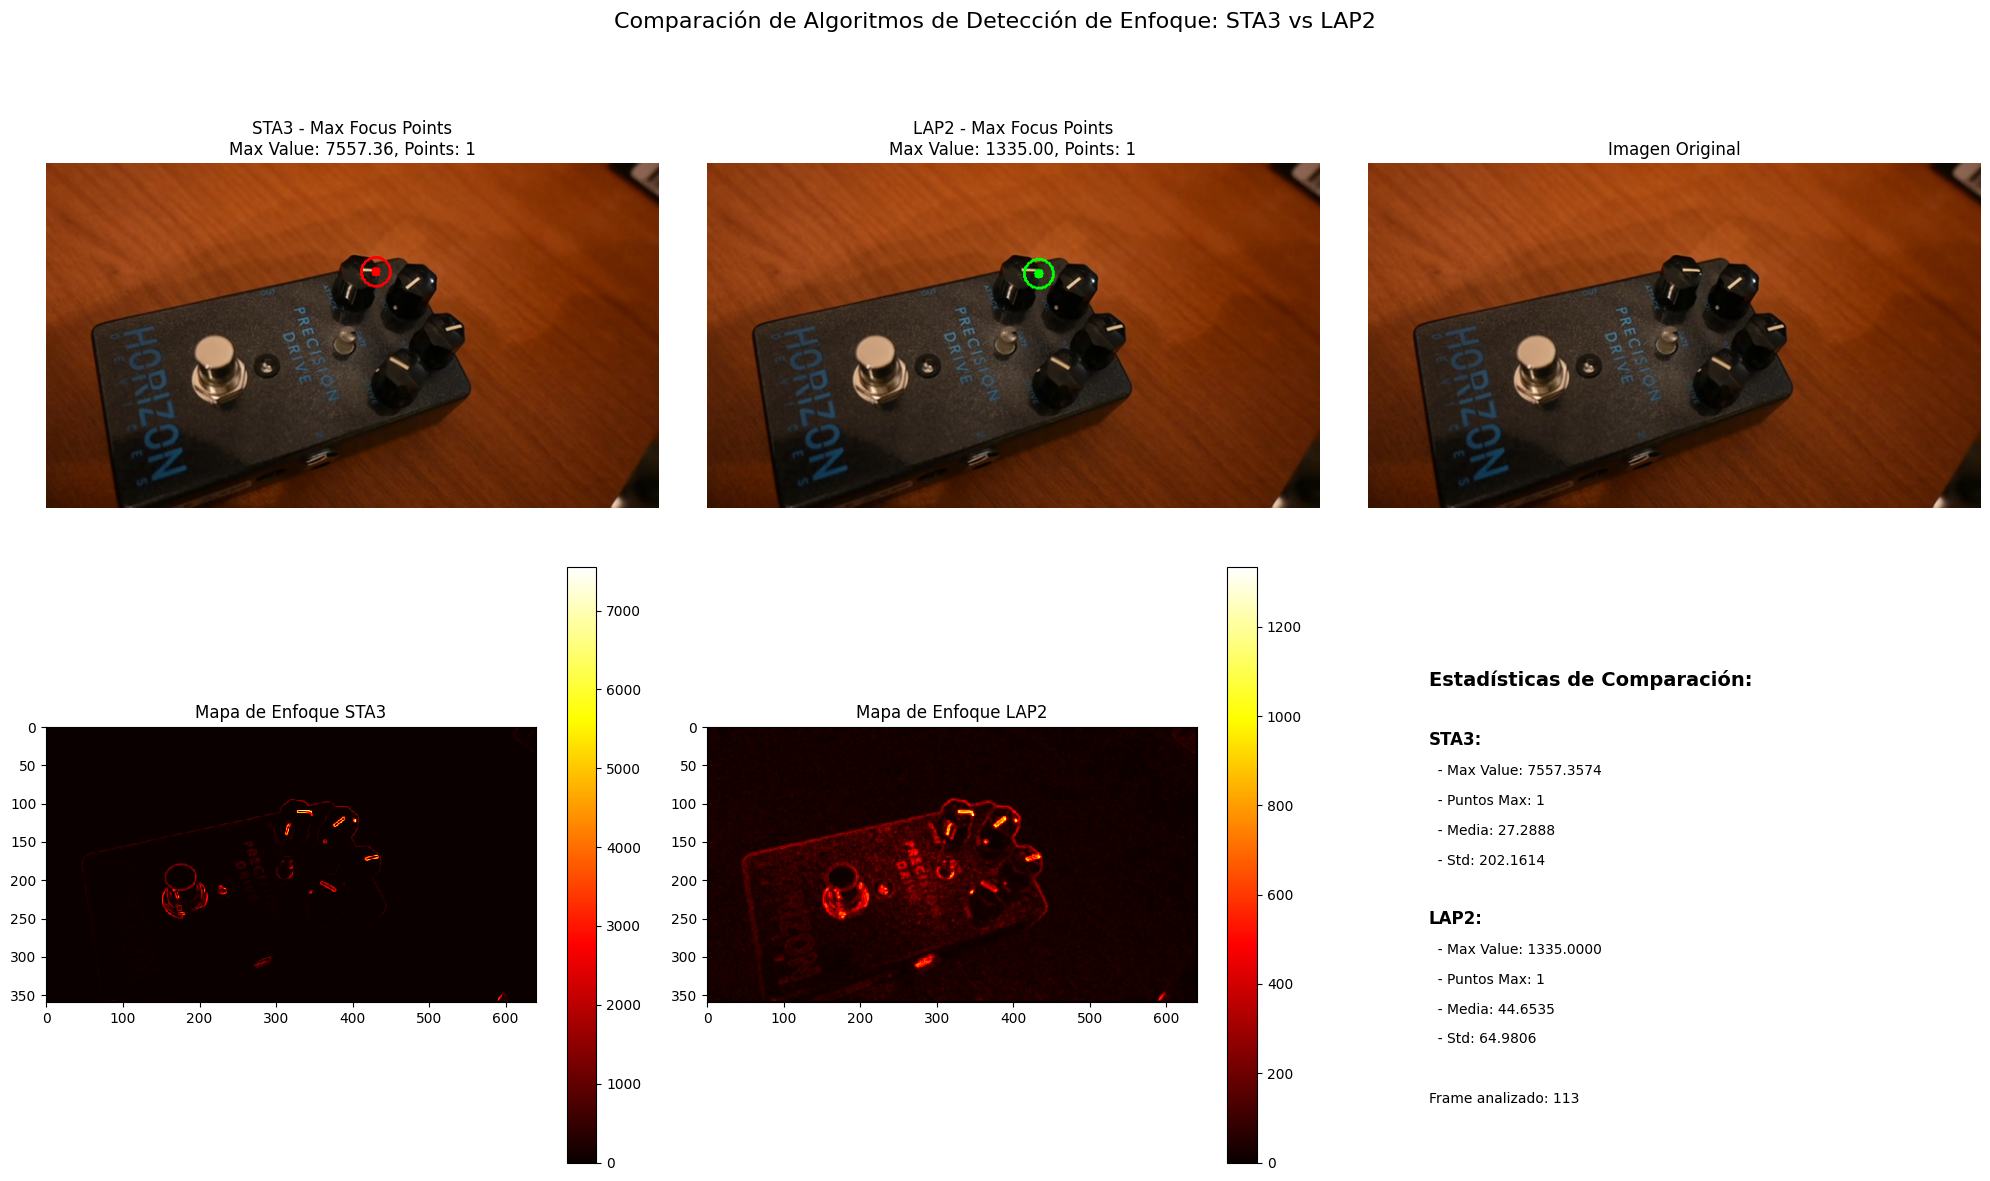

In [ ]:
# Comparación visual de ambos algoritmos en un frame específico
input_path = "data/focus_video.mov"
cap = cv2.VideoCapture(input_path)

# Usar el frame con mejor calidad que encontramos anteriormente
cap.set(cv2.CAP_PROP_POS_FRAMES, best_frame_idx)
ret, test_frame = cap.read()
cap.release()

# Calcular mapas de enfoque con ambos algoritmos
focus_map_sta3 = calculate_sta3_focus_measure(test_frame, window_size=3)
focus_map_lap2 = calculate_lap2_focus_measure(test_frame, window_size=3)

# Encontrar puntos de máximo enfoque
max_points_sta3, max_value_sta3 = max_focus_points(focus_map_sta3)
max_points_lap2, max_value_lap2 = max_focus_points(focus_map_lap2)

# Crear imágenes con puntos superpuestos
frame_sta3 = test_frame.copy()
frame_lap2 = test_frame.copy()

# Dibujar puntos STA3
for point in max_points_sta3:
    row, col = point
    cv2.circle(frame_sta3, (col, row), 5, (0, 0, 255), -1)
    cv2.circle(frame_sta3, (col, row), 15, (0, 0, 255), 2)

# Dibujar puntos LAP2
for point in max_points_lap2:
    row, col = point
    cv2.circle(frame_lap2, (col, row), 5, (0, 255, 0), -1)
    cv2.circle(frame_lap2, (col, row), 15, (0, 255, 0), 2)

# Visualización comparativa
plt.figure(figsize=(20, 12))

# Fila superior: Imágenes originales con puntos
plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(frame_sta3, cv2.COLOR_BGR2RGB))
plt.title(f'STA3 - Max Focus Points\nMax Value: {max_value_sta3:.2f}, Points: {len(max_points_sta3)}')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(cv2.cvtColor(frame_lap2, cv2.COLOR_BGR2RGB))
plt.title(f'LAP2 - Max Focus Points\nMax Value: {max_value_lap2:.2f}, Points: {len(max_points_lap2)}')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
plt.title('Imagen Original')
plt.axis('off')

# Fila inferior: Mapas de enfoque
plt.subplot(2, 3, 4)
plt.imshow(focus_map_sta3, cmap='hot', interpolation='nearest')
plt.title('Mapa de Enfoque STA3')
plt.colorbar()

plt.subplot(2, 3, 5)
plt.imshow(focus_map_lap2, cmap='hot', interpolation='nearest')
plt.title('Mapa de Enfoque LAP2')
plt.colorbar()

plt.subplot(2, 3, 6)
# Comparación estadística
plt.text(0.1, 0.8, f'Estadísticas de Comparación:', fontsize=14, fontweight='bold')
plt.text(0.1, 0.7, f'STA3:', fontsize=12, fontweight='bold')
plt.text(0.1, 0.65, f'  - Max Value: {max_value_sta3:.4f}', fontsize=10)
plt.text(0.1, 0.6, f'  - Puntos Max: {len(max_points_sta3)}', fontsize=10)
plt.text(0.1, 0.55, f'  - Media: {np.mean(focus_map_sta3):.4f}', fontsize=10)
plt.text(0.1, 0.5, f'  - Std: {np.std(focus_map_sta3):.4f}', fontsize=10)

plt.text(0.1, 0.4, f'LAP2:', fontsize=12, fontweight='bold')
plt.text(0.1, 0.35, f'  - Max Value: {max_value_lap2:.4f}', fontsize=10)
plt.text(0.1, 0.3, f'  - Puntos Max: {len(max_points_lap2)}', fontsize=10)
plt.text(0.1, 0.25, f'  - Media: {np.mean(focus_map_lap2):.4f}', fontsize=10)
plt.text(0.1, 0.2, f'  - Std: {np.std(focus_map_lap2):.4f}', fontsize=10)

plt.text(0.1, 0.1, f'Frame analizado: {best_frame_idx}', fontsize=10)
plt.axis('off')

plt.suptitle('Comparación de Algoritmos de Detección de Enfoque: STA3 vs LAP2', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
## Implementación de Unsharp Masking para expandir zonas de enfoque
def apply_unsharp_mask(
    image: np.ndarray, 
    kernel_size: Tuple[int, int] = (5, 5), 
    sigma: float = 1.0, 
    amount: float = 1.5, 
    threshold: float = 0
) -> np.ndarray:

    def apply_single_channel(channel: np.ndarray) -> np.ndarray:
        channel_float = channel.astype(np.float32)
        
        # Create Gaussian blur
        gaussian = cv2.GaussianBlur(channel_float, kernel_size, sigma)
        
        # Create unsharp mask
        unsharp_mask = channel_float - gaussian
        
        # Apply threshold if specified
        if threshold > 0:
            unsharp_mask = np.where(np.abs(unsharp_mask) < threshold, 0, unsharp_mask)
        
        # Apply mask with amount factor
        sharpened = channel_float + (amount * unsharp_mask)
        
        return np.clip(sharpened, 0, 255).astype(np.uint8)
    
    if len(image.shape) == 3:
        # Apply to each channel
        result = np.zeros_like(image)
        for i in range(image.shape[2]):
            result[:, :, i] = apply_single_channel(image[:, :, i])
        return result
    else:
        return apply_single_channel(image)

def calculate_focus_with_unsharp(
    image: np.ndarray, 
    algorithm: str = 'sta3', 
    window_size: int = 3, 
    unsharp_params: Optional[Dict] = None
) -> Tuple[np.ndarray, np.ndarray]:
    
    if unsharp_params is None:
        unsharp_params = {
            'kernel_size': (5, 5),
            'sigma': 1.0,
            'amount': 1.5,
            'threshold': 0
        }
    
    # Apply unsharp masking
    enhanced_image = apply_unsharp_mask(image, **unsharp_params)
    
    # Calculate focus on enhanced image
    if algorithm.lower() == 'sta3':
        focus_map = calculate_sta3_focus_measure(enhanced_image, window_size)
    elif algorithm.lower() == 'lap2':
        focus_map = calculate_lap2_focus_measure(enhanced_image, window_size)
    else:
        raise ValueError("Algorithm must be 'sta3' or 'lap2'")
    
    return focus_map, enhanced_image

In [ ]:
# Generar video con Unsharp Masking aplicado para mejor visualización
def create_focus_points_video_with_unsharp(input_path, output_path, algorithm='sta3', 
                                          window_size=3, unsharp_params=None, max_frames=None):
    if unsharp_params is None:
        unsharp_params = {'kernel_size': (5, 5), 'sigma': 1.0, 'amount': 1.5, 'threshold': 0}
    
    cap = cv2.VideoCapture(input_path)
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if max_frames:
        frame_count = min(max_frames, frame_count)
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    algorithm_name = "STA3 + Unsharp" if algorithm.lower() == 'sta3' else "LAP2 + Unsharp"
    
    print(f"Generando video con {algorithm_name} en {frame_count} frames...")
    
    for frame_idx in tqdm(range(frame_count), desc=f"Generating {algorithm_name} video"):
        ret, frame = cap.read()
        
        # Aplicar unsharp masking y calcular enfoque
        focus_map, enhanced_image = calculate_focus_with_unsharp(
            frame, algorithm, window_size, unsharp_params
        )
        max_points, max_value = max_focus_points(focus_map)
        
        # Usar la imagen realzada para el video
        output_frame = enhanced_image.copy()
        
        # Dibujar los puntos de máximo enfoque
        for point in max_points:
            row, col = point
            cv2.circle(output_frame, (col, row), 5, (0, 255, 255), -1)  
            cv2.circle(output_frame, (col, row), 15, (0, 255, 255), 2)
        
        # Texto informativo
        text1 = f'Frame: {frame_idx} | {algorithm_name}'
        text2 = f'Max Focus: {max_value:.2f} | Points: {len(max_points)}'
        text3 = f'Unsharp: σ={unsharp_params["sigma"]}, Amount={unsharp_params["amount"]}'
        
        cv2.putText(output_frame, text1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, text1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1)
        cv2.putText(output_frame, text2, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(output_frame, text2, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 1)
        cv2.putText(output_frame, text3, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.putText(output_frame, text3, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        out.write(output_frame)
        
    cap.release()
    out.release()
    
    print(f"Video con Unsharp Masking guardado en: {output_path}")
    return output_path

# Generar videos de demostración con Unsharp Masking
input_video = "data/focus_video.mov"

# Configuraciones de Unsharp Masking para demostrar
unsharp_moderate = {'kernel_size': (5, 5), 'sigma': 1.0, 'amount': 1.5, 'threshold': 0}
unsharp_intense = {'kernel_size': (7, 7), 'sigma': 1.5, 'amount': 2.0, 'threshold': 0}

print("Generando videos con Unsharp Masking...")

# Video STA3 + Unsharp Masking moderado
output_sta3_unsharp = "outputs/focus_points_STA3_Unsharp_Moderate.mp4"
create_focus_points_video_with_unsharp(
    input_video, output_sta3_unsharp, 'sta3', 3, unsharp_moderate, max_frames=60
)

# Video LAP2 + Unsharp Masking intenso  
output_lap2_unsharp = "outputs/focus_points_LAP2_Unsharp_Intense.mp4"
create_focus_points_video_with_unsharp(
    input_video, output_lap2_unsharp, 'lap2', 3, unsharp_intense, max_frames=60
)

Generando videos con Unsharp Masking...
Generando video con STA3 + Unsharp en 60 frames...


Generating STA3 + Unsharp video: 100%|██████████| 60/60 [02:37<00:00,  2.63s/it]


Video con Unsharp Masking guardado en: outputs/focus_points_STA3_Unsharp_Moderate.mp4
Generando video con LAP2 + Unsharp en 60 frames...


Generating LAP2 + Unsharp video: 100%|██████████| 60/60 [01:42<00:00,  1.71s/it]

Video con Unsharp Masking guardado en: outputs/focus_points_LAP2_Unsharp_Intense.mp4


'outputs/focus_points_LAP2_Unsharp_Intense.mp4'

In [26]:
# Definir configuraciones de Unsharp Masking para experimentar
unsharp_configs = {
    'moderate': {'kernel_size': (5, 5), 'sigma': 1.0, 'amount': 1.5, 'threshold': 0},
    'intense': {'kernel_size': (7, 7), 'sigma': 1.5, 'amount': 2.0, 'threshold': 0},
    'subtle': {'kernel_size': (3, 3), 'sigma': 0.8, 'amount': 1.2, 'threshold': 0}
}

def calculate_image_quality_with_unsharp(image, unsharp_params):
    """Calcular calidad de imagen completa aplicando unsharp masking primero"""
    enhanced_image = apply_unsharp_mask(image, **unsharp_params)
    return calculate_image_quality(enhanced_image)

def calculate_image_quality_roi_with_unsharp(image, porcentage_roi, unsharp_params):
    """Calcular calidad de ROI aplicando unsharp masking primero"""
    enhanced_image = apply_unsharp_mask(image, **unsharp_params)
    return calculate_image_quality_roi(enhanced_image, porcentage_roi)

In [28]:
# Procesar todo el video con diferentes configuraciones de Unsharp Masking
input_path = "data/focus_video.mov"
results_unsharp = {}

# Obtener información básica del video
cap_info = cv2.VideoCapture(input_path)
total_frames = int(cap_info.get(cv2.CAP_PROP_FRAME_COUNT))
cap_info.release()


for config_idx, (config_name, unsharp_params) in enumerate(unsharp_configs.items(), 1):
    print(f"\nProcesando configuración {config_idx}/3: {config_name}")
    
    cap = cv2.VideoCapture(input_path)
    
    # Métricas para esta configuración
    quality_scores_full = []
    quality_scores_5p = []
    quality_scores_10p = []
    
    
    for frame_idx in tqdm(range(total_frames), desc=f"Processing {config_name}"):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Métrica de frame completo con Unsharp
        quality_full = calculate_image_quality_with_unsharp(frame, unsharp_params)
        quality_scores_full.append(quality_full)
        
        # Métricas ROI con Unsharp  
        quality_5p = calculate_image_quality_roi_with_unsharp(frame, 0.05, unsharp_params)
        quality_scores_5p.append(quality_5p)
        
        quality_10p = calculate_image_quality_roi_with_unsharp(frame, 0.10, unsharp_params)
        quality_scores_10p.append(quality_10p)
    
    cap.release()
    
    # Encontrar máximos
    max_full = np.argmax(quality_scores_full)
    max_5p = np.argmax(quality_scores_5p)
    max_10p = np.argmax(quality_scores_10p)
    
    # Guardar resultados
    results_unsharp[config_name] = {
        'full_frame': {
            'scores': quality_scores_full,
            'max_frame': max_full,
            'max_value': quality_scores_full[max_full]
        },
        'roi_5p': {
            'scores': quality_scores_5p,
            'max_frame': max_5p,
            'max_value': quality_scores_5p[max_5p]
        },
        'roi_10p': {
            'scores': quality_scores_10p,
            'max_frame': max_10p,
            'max_value': quality_scores_10p[max_10p]
        }
    }
    


Procesando configuración 1/3: moderate


Processing moderate: 100%|██████████| 171/171 [00:01<00:00, 158.89it/s]



Procesando configuración 2/3: intense


Processing intense: 100%|██████████| 171/171 [00:01<00:00, 143.57it/s]



Procesando configuración 3/3: subtle


Processing subtle: 100%|██████████| 171/171 [00:01<00:00, 170.46it/s]


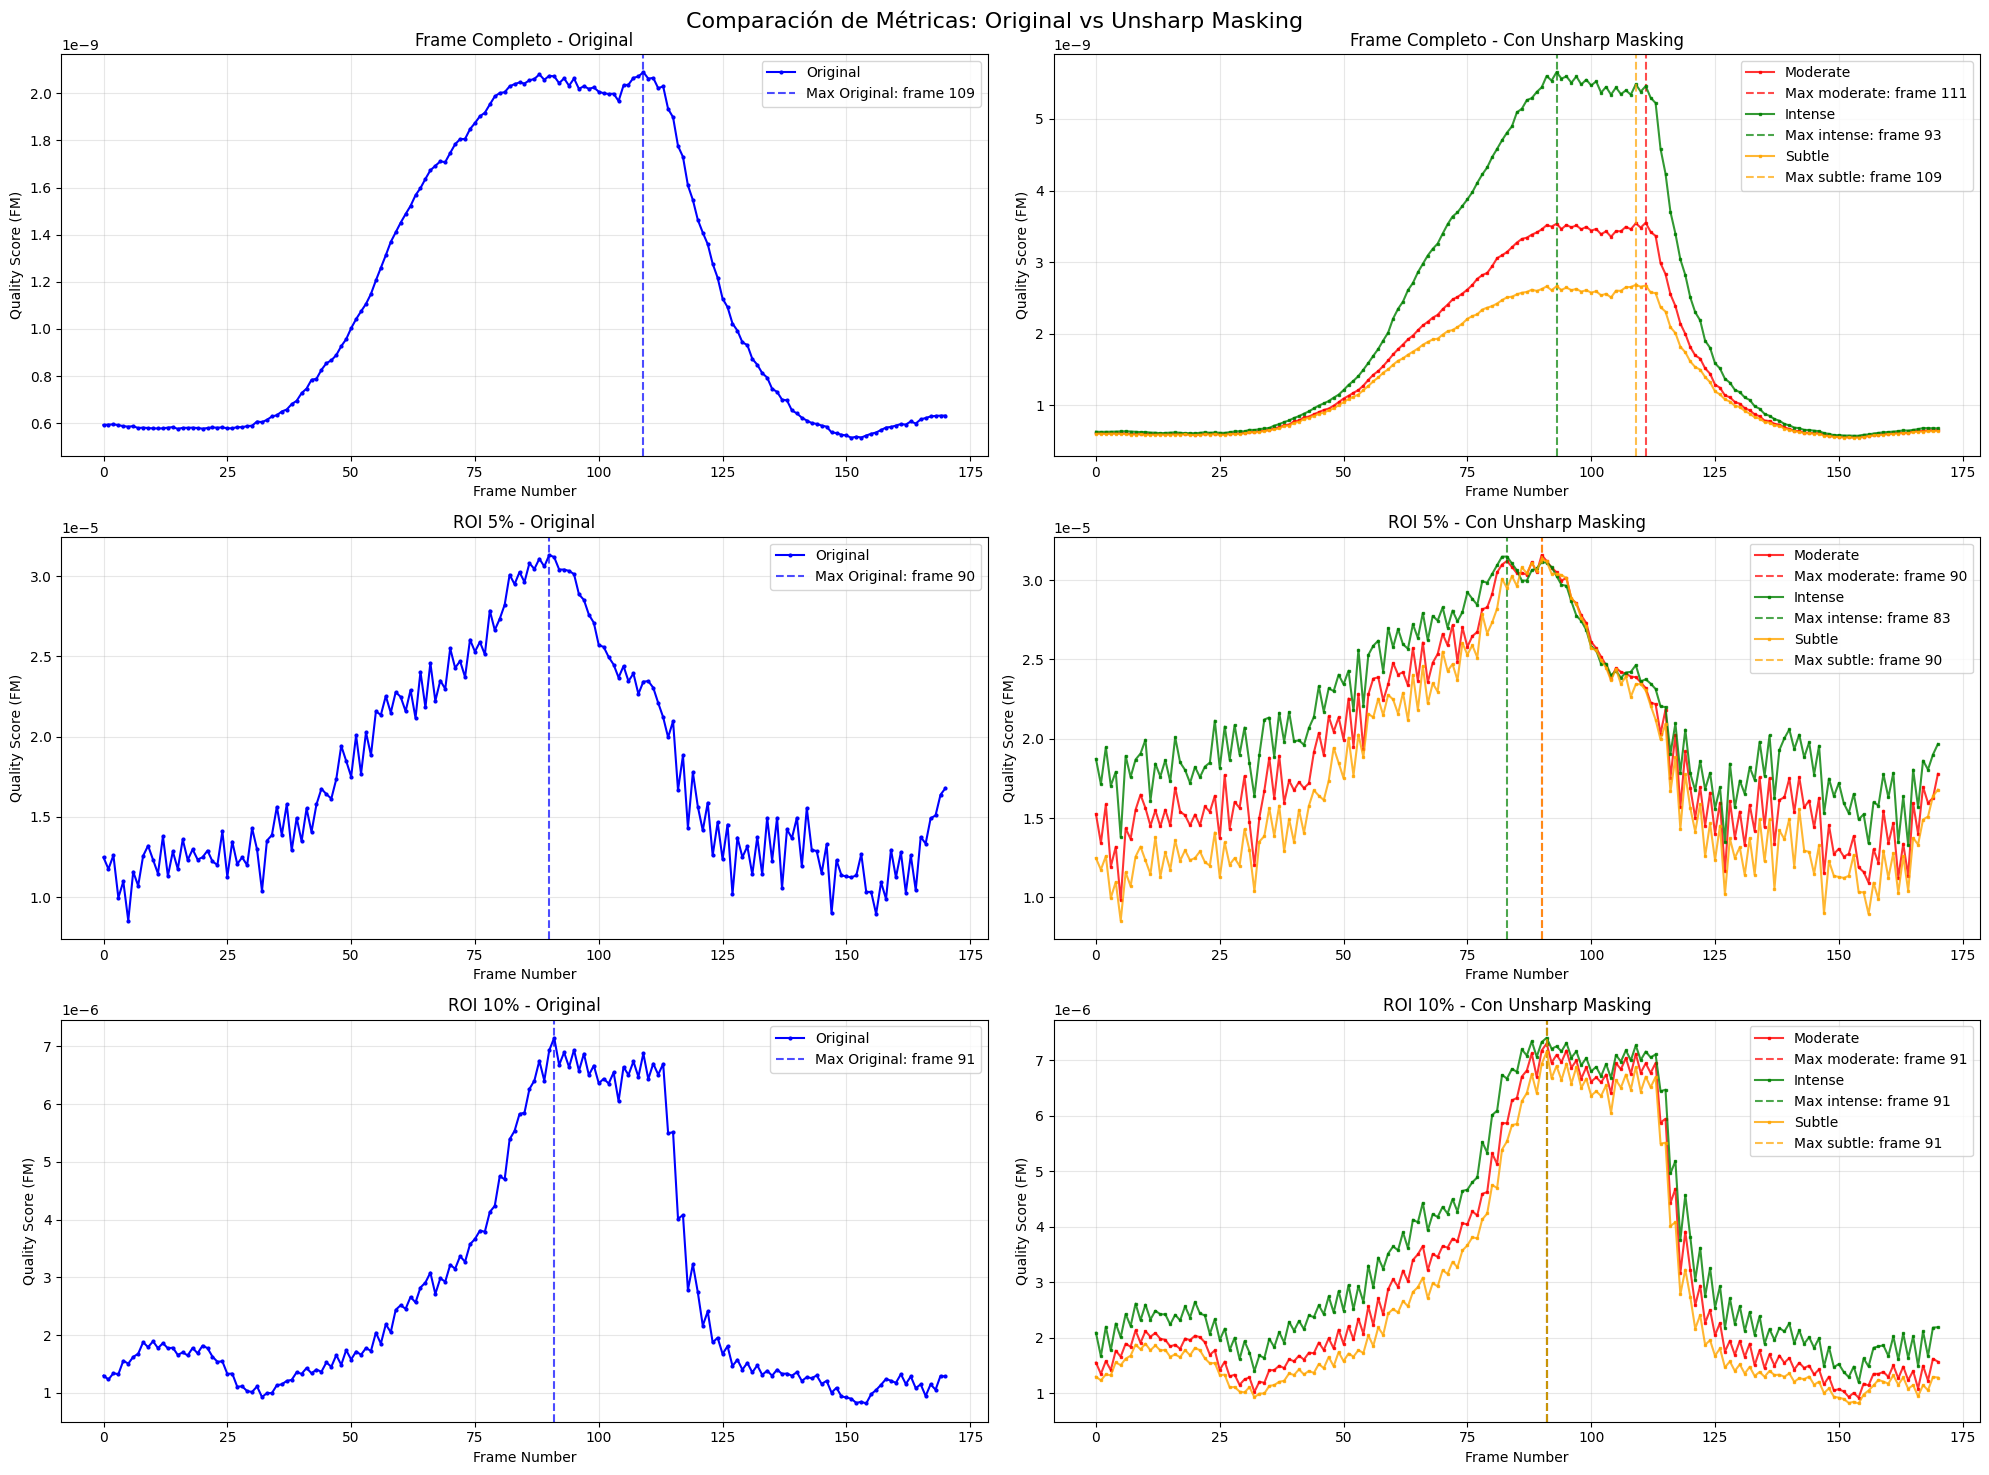

In [29]:
# Comparación visual: Original vs Unsharp Masking
plt.figure(figsize=(20, 15))

# Crear subplots para cada métrica y configuración
metrics = ['full_frame', 'roi_5p', 'roi_10p']
metric_names = ['Frame Completo', 'ROI 5%', 'ROI 10%']

for i, (metric_key, metric_name) in enumerate(zip(metrics, metric_names)):
    plt.subplot(3, 2, i*2 + 1)
    
    # Gráfico original 
    if metric_key == 'full_frame':
        original_scores = quality_scores
        original_max = np.argmax(quality_scores)
    elif metric_key == 'roi_5p':
        original_scores = quality_scores_5p  
        original_max = np.argmax(quality_scores_5p)
    else:  # roi_10p
        original_scores = quality_scores_10p
        original_max = np.argmax(quality_scores_10p)
    
    plt.plot(original_scores, 'b-', marker='o', markersize=2, label='Original')
    plt.axvline(x=original_max, color='blue', linestyle='--', alpha=0.7, 
                label=f'Max Original: frame {original_max}')
    plt.title(f'{metric_name} - Original')
    plt.xlabel('Frame Number')
    plt.ylabel('Quality Score (FM)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Gráfico con diferentes configuraciones de Unsharp
    plt.subplot(3, 2, i*2 + 2)
    
    colors = ['red', 'green', 'orange']
    for j, (config_name, config_results) in enumerate(results_unsharp.items()):
        scores = config_results[metric_key]['scores']
        max_frame = config_results[metric_key]['max_frame']
        
        plt.plot(scores, color=colors[j], marker='s', markersize=2, 
                label=f'{config_name.capitalize()}', alpha=0.8)
        plt.axvline(x=max_frame, color=colors[j], linestyle='--', alpha=0.7,
                   label=f'Max {config_name}: frame {max_frame}')
    
    plt.title(f'{metric_name} - Con Unsharp Masking')
    plt.xlabel('Frame Number') 
    plt.ylabel('Quality Score (FM)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle('Comparación de Métricas: Original vs Unsharp Masking', fontsize=16)
plt.tight_layout()
plt.show()

In [30]:
# Tabla de resultados comparativos
# Resultados originales para comparar
original_results = {
    'Frame Completo': {'max_frame': np.argmax(quality_scores), 'max_value': np.max(quality_scores)},
    'ROI 5%': {'max_frame': np.argmax(quality_scores_5p), 'max_value': np.max(quality_scores_5p)},
    'ROI 10%': {'max_frame': np.argmax(quality_scores_10p), 'max_value': np.max(quality_scores_10p)}
}

metric_mapping = {
    'full_frame': 'Frame Completo',
    'roi_5p': 'ROI 5%', 
    'roi_10p': 'ROI 10%'
}

for metric_key, metric_name in metric_mapping.items():
    print(f"{metric_name.upper()}")
    print("-" * 50)
    
    # Resultado original
    orig = original_results[metric_name]
    print(f"Original      : Frame {orig['max_frame']:3d} | Valor: {orig['max_value']:.2e}")
    
    # Resultados con Unsharp
    for config_name, config_results in results_unsharp.items():
        result = config_results[metric_key]
        improvement = result['max_value'] / orig['max_value']
        print(f"Unsharp {config_name:6s}: Frame {result['max_frame']:3d} | Valor: {result['max_value']:.2e} | Mejora: {improvement:.2f}x")
    
    print()

# Mejores configuraciones por métrica
print("MEJORES CONFIGURACIONES")
print("-" * 50)
for metric_key, metric_name in metric_mapping.items():
    best_config = None
    best_improvement = 0
    original_value = original_results[metric_name]['max_value']
    
    for config_name, config_results in results_unsharp.items():
        improvement = config_results[metric_key]['max_value'] / original_value
        if improvement > best_improvement:
            best_improvement = improvement
            best_config = config_name
    
    print(f"{metric_name:15s}: {best_config.capitalize():8s} (mejora: {best_improvement:.2f}x)")



FRAME COMPLETO
--------------------------------------------------
Original      : Frame 109 | Valor: 2.09e-09
Unsharp moderate: Frame 111 | Valor: 3.55e-09 | Mejora: 1.70x
Unsharp intense: Frame  93 | Valor: 5.65e-09 | Mejora: 2.70x
Unsharp subtle: Frame 109 | Valor: 2.68e-09 | Mejora: 1.28x

ROI 5%
--------------------------------------------------
Original      : Frame  90 | Valor: 3.13e-05
Unsharp moderate: Frame  90 | Valor: 3.16e-05 | Mejora: 1.01x
Unsharp intense: Frame  83 | Valor: 3.15e-05 | Mejora: 1.01x
Unsharp subtle: Frame  90 | Valor: 3.13e-05 | Mejora: 1.00x

ROI 10%
--------------------------------------------------
Original      : Frame  91 | Valor: 7.15e-06
Unsharp moderate: Frame  91 | Valor: 7.30e-06 | Mejora: 1.02x
Unsharp intense: Frame  91 | Valor: 7.40e-06 | Mejora: 1.04x
Unsharp subtle: Frame  91 | Valor: 7.15e-06 | Mejora: 1.00x

MEJORES CONFIGURACIONES
--------------------------------------------------
Frame Completo : Intense  (mejora: 2.70x)
ROI 5%         :